### Check

In [113]:
import os
import sys
import numpy as np
import scipy.linalg as slin
import scipy.optimize as sopt
from scipy.special import expit as sigmoid
import matplotlib.pyplot as plt
from importlib import reload  # Python 3.4+

from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import OrthogonalMatchingPursuit

# import notears
sys.path.append("..")

import helper.helper as h
import helper.methods as m

from notears.notears.notears import utils
from notears.notears.notears import linear

reload(m)
reload(h)

reload(utils)
reload(linear)

<module 'notears.notears.notears.linear' from '..\\notears\\notears\\notears\\linear.py'>

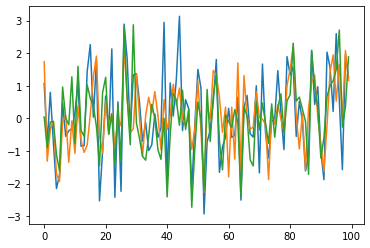

h: 0.0.
rho: 1e+22.
loss: (1.3148086666988374, array([-1.29567309e+00,  1.28781945e+00,  4.16263501e-01, -2.05426430e-03,
       -1.49901454e+00, -3.35303557e-05, -6.14149149e-04,  4.22139607e-01,
       -1.21490664e+00,  1.29567309e+00, -1.28781945e+00, -4.16263501e-01,
        2.05426430e-03,  1.49901454e+00,  3.35303557e-05,  6.14149149e-04,
       -4.22139607e-01,  1.21490664e+00])).
True W:
[[0.   0.   0.  ]
 [0.51 0.   0.67]
 [0.61 0.   0.  ]].

NOTEARS W:
[[0.   0.   0.  ]
 [0.47 0.   0.62]
 [0.58 0.   0.  ]].

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 3}


In [126]:
# set random seed
# utils.set_random_seed(1)
T, n, s0, graph_type, sem_type = 100, 3, 3, 'ER', 'gauss'
B_true = utils.simulate_dag(n, s0, graph_type)
W_true = utils.simulate_parameter(B_true, w_ranges = ((-.75, -.5), (0.5, .75)))
X = utils.simulate_linear_sem(W_true, T, sem_type)
plt.plot(X)
plt.show()
W_est = linear.notears_linear(X, lambda1=0.0, loss_type='l2', w_threshold = 0.01, h_tol = 1e-16, rho_max = 1e32)

# print W
print(f"True W:\n{np.round(W_true, 2)}.\n")
print(f"NOTEARS W:\n{np.round(W_est, 2)}.\n")

acc = utils.count_accuracy(B_true, W_est != 0)
print(acc)

In [127]:
## Assumption 1.1
# first, we must normalize all data
norm_const = np.sqrt((X ** 2).sum(axis=0) / (n * T))

# normalize X and Y
X_norm = X / norm_const

# vectorize data
X_norm_vec = np.kron(np.eye(n, dtype=float), X_norm)

# get dimensions
n_paper, d_paper = np.shape(X_norm_vec)

# consequently, the matrix W must also be "adjusted"
W_norm = W_true.T * norm_const
W_norm = W_norm.T / norm_const

# print normalized basis vectors
print(f"Normalized basis vectors: {[round(np.linalg.norm(X_norm_vec[:, i]) ** 2 / n_paper, 4) for i in range(d_paper)]}.\n")

# new W
print(f"New normalized W:\n{np.round(W_norm, 2)}.")

W_est_norm = linear.notears_linear(X_norm, lambda1=0.0, loss_type='l2', w_threshold = 0.01, h_tol = 1e-16, rho_max = 1e32)
print(W_est_norm)
print(W_norm)

Normalized basis vectors: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].

New normalized W:
[[0.   0.   0.  ]
 [0.38 0.   0.62]
 [0.49 0.   0.  ]].
h: 0.0.
rho: 1e+22.
loss: (3.1789656211985142, array([-1.16691063, -0.68243225, -0.00235078, -0.00276696, -0.60163677,
       -0.00546063, -1.28538091,  1.20819927, -1.49252893,  1.16691063,
        0.68243225,  0.00235078,  0.00276696,  0.60163677,  0.00546063,
        1.28538091, -1.20819927,  1.49252893])).
[[0.         0.         0.51650152]
 [0.61754761 0.         0.25056104]
 [0.         0.         0.        ]]
[[0.         0.         0.        ]
 [0.38182109 0.         0.61814085]
 [0.49196136 0.         0.        ]]


In [116]:
## Assumption 1.2
# the data generating matrix constitues a DAG
print(f"Is W a DAG: {h.is_dag(W_true)[0]}.")

Is W a DAG: True.


In [128]:
def mu(W, X):
    """Computes this strange mu"""
    
    # restrict X only to zero entries; X_F_bar
    X_F_bar = X[:, np.where(W.T.flatten() != 0)[0]]
    
    print([OLS(X[:, index], X_F_bar).fit().params for index in np.where(W.T.flatten() == 0)[0]])
    # return this mu
    return max([np.linalg.norm(OLS(X[:, index], X_F_bar).fit().params, 1) for index in np.where(W.T.flatten() == 0)[0]])

mu(W_norm, X_norm_vec)

[array([0.35529806, 0.46661071, 0.        ]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0.        , 0.        , 0.62075638]), array([0.        , 0.        , 0.56890746])]


0.8219087688118056

In [118]:
def rho(W, X):
    """Compute rho"""
    
    # restrict X only to zero entries; X_F_bar
    X_F_bar = X[:, np.where(W.flatten() != 0)[0]]
    
    # compute restricted design matrix 1 / n_paper X_F_bar.T @ X_F_bar
    design_matrix = X_F_bar.T @ X_F_bar / n_paper
    
    # compute rho   
    return min(np.linalg.eig(design_matrix)[0])
    
rho(W_norm, X_norm_vec)

0.14583186098913037

In [119]:
sigma = np.sqrt(max(np.diag(np.cov(X_norm.T))))
print(f"Maximum covariance of all normalized y: {round(sigma, 4)}.")

Maximum covariance of all normalized y: 2.229.


In [120]:
eta = 0.25

# compute smallest epsilon
epsilon = 1 / (1 - mu(W_norm, X_norm_vec)) * sigma * np.sqrt(2 * np.log(2 * d_paper / eta))

print(f"Lower bound on epsilon: {round(epsilon, 4)}.")

Lower bound on epsilon: -12.8449.


In [121]:
# all true coefficients must be above this threshold:
print(f"Lower bound on coefficients: {round(3 * epsilon / (rho(W_norm, X_norm_vec) * np.sqrt(n_paper)), 4)}.")

Lower bound on coefficients: -11.8172.


In [112]:
## Transform data
X = np.array(X)

# Blockwise repeat of X
X_large = X_norm_vec # np.kron(np.eye(n, dtype=float), X)

# Stack all X on top of each other for y
y_large = (X_norm.T).reshape(T * n, 1)

# make sure that we cannot pick the element itself
for i in range(n):
    X_large[:, i * (n + 1)] = np.zeros(T * n)
    
omp = OrthogonalMatchingPursuit(n_nonzero_coefs = 10)
omp_fit = omp.fit(X_large, y_large)

print(omp_fit.coef_.reshape(n, n).T)
W_OMP_paper = OMP_paper(X_large, y_large[:, 0], max_coefs = 10, tol = 0.01)
print(W_OMP_paper)

[[ 0.          0.          0.42919238  0.32940465 -0.46147609]
 [ 0.          0.          0.         -0.62645332 -0.68770912]
 [ 0.          0.          0.          0.          0.53720842]
 [ 0.88341329 -0.79934196  0.          0.          0.        ]
 [-0.36088006  0.          0.5482787   0.          0.        ]]
[[ 0.          0.          0.42856916  0.32897703 -0.46174072]
 [ 0.          0.          0.         -0.62612198 -0.68750294]
 [ 0.          0.          0.          0.          0.53677669]
 [ 0.88266988 -0.79980343  0.          0.          0.        ]
 [-0.36042464  0.          0.54838982  0.          0.        ]]


In [110]:
def OMP_paper(X, Y, max_coefs = int(1e10), tol = 4):
    
    # normalize bases
    
    # intialize F
    F = set()
    
    # initialize beta
    betas = np.zeros(d_paper)
    
    for i in range(min(d_paper, max_coefs)):
        # find the i that maximizes
        i_max = np.argmax([np.abs(X[:, i] @ (X @ betas - Y)) for i in range(d_paper)])
        i_max_value = max([np.abs(X[:, i] @ (X @ betas - Y)) for i in range(d_paper)])
        
        # check if the gain is large enough
        if max([np.abs(X[:, i] @ (X @ betas - Y)) for i in range(d_paper)]) <= tol: break
        
        # add index to F
        F.add(i_max)
        
        # update residuals
        betas = update_betas(list(F), Y)
        
    return betas.reshape(n, n).T


print(np.round(W_OMP_paper, 1))

[[ 0.   0.   0.4  0.3 -0.5]
 [ 0.   0.   0.  -0.6 -0.7]
 [ 0.   0.   0.   0.   0.5]
 [ 0.9 -0.8  0.   0.   0. ]
 [-0.4  0.   0.5  0.   0. ]]


In [101]:
def update_betas(F, Y):
    """Compute OLS coefficients using only the entries in F"""
    
    # fit only using coefficients in F
    X_F = X_large[:, F]
    
    # fit
    ols_fit = OLS(Y, X_F).fit()
    
    # get parameters
    params = np.zeros(d_paper)
    params[F] = ols_fit.params
    
    return params